# Introduction to TensorFlow and Keras

# Problems:

### Problem 1: 

The MNIST dataset is a collection of images of handwritten numbers ranging from 0 to 9. I will train a deep learning model on the dataset to build a classifier. My goal is to hit 98% accuracy.

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('legend', fontsize=18)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import keras
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[:5000]
y_train = y_train[:5000]
X_test = X_test[:1000]
y_test = y_test[:1000]


y_traind = pd.get_dummies(y_train)
y_testd = pd.get_dummies(y_test)


#scale pixels down to be between 0 and 1 (these work better with our activation functions below)

X_train, X_test = X_train/255., X_test/255.

print("X_train shape:", X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (5000, 28, 28)
y_train shape: (5000,)
X_test shape: (1000, 28, 28)
y_test shape: (1000,)


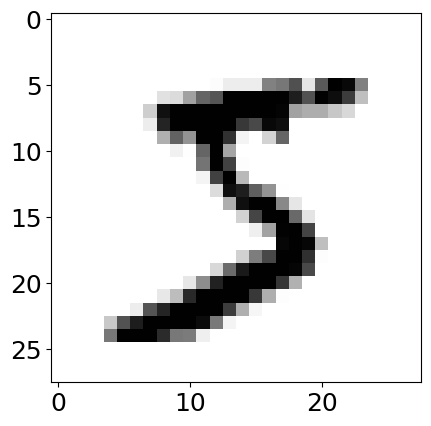

In [3]:
plt.imshow(X_train[0], cmap="binary")

In [4]:
#need to reshape the data for the model to work

X_train_reshape = X_train.reshape(-1, 28*28)
X_test_reshape = X_test.reshape(-1, 28*28)

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

I was able to very easily achieve high accuracy on the training data. As I made my model more and more sophisticated, adding layers and tuning the hyperparamaters, I eventually encountered an overfitting problem. This was evidenced by the fact that accuracy on the training set swells to 100% but validation loss flatlines and even begins to increase as seen below. 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 300)               90300     
                                                                 
 dense_5 (Dense)             (None, 10)                3010      
                                                                 
Total params: 328,810
Trainable params: 328,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
157/157 [==============================] - 2s 7ms/step - loss: 0.5290 - accuracy: 0.8484 - val_loss: 0.3857 - val_accuracy: 0.8820
Epoch 2/40
157/157 [==================

(0.0, 1.0)

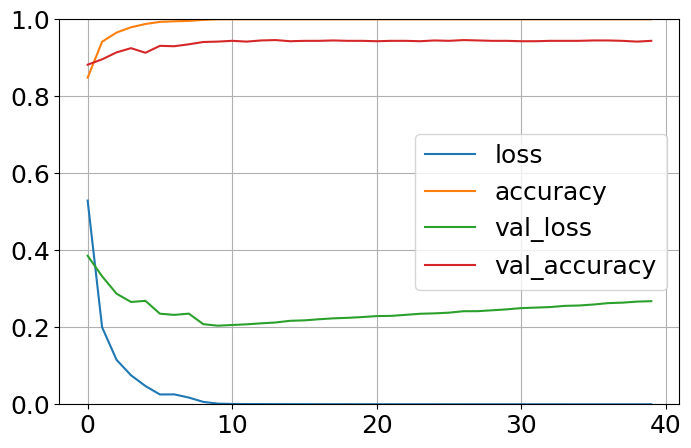

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_dim = 784))
model.add(keras.layers.Dense(300, activation = 'relu'))
model.add(keras.layers.Dense(300, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax')) #softmax or sigmoid should be the activation in the output layer since the target is a categorical

model.summary()

model.compile(loss="categorical_crossentropy", #categorical crossentropy is used when the target is a categorical
              optimizer="adam",
              metrics=["accuracy"])

history = model.fit(X_train_reshape, y_traind, epochs=40,
                    validation_data=(X_test_reshape, y_testd))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 1)

I explored a number of ways of addressing the overfitting, such as dropout layers. After manually inspecting the gradients I determined that they were vanishing, so I added batch normalization to regulate that. 

I gradually realized that the level of sophistication I needed in my model was such that I was bound to encounter overfitting, unless I expanded my dataset. 

(I also at one point noticed that sigmoid as the activation function in the output layer gave a mild improvement in accuracy.

In [9]:
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

X_train_full = X_train_full.reshape(-1, 28*28)
X_test_full = X_test_full.reshape(-1, 28*28)

y_traind_full = pd.get_dummies(y_train_full)
y_testd_full = pd.get_dummies(y_test_full)

X_train_full, X_test_full = X_train_full/255., X_test_full/255.

print("X_train_full shape:", X_train_full.shape)
print('y_train_full shape_full:', y_train_full.shape)
print('X_test_full shape_full:', X_test_full.shape)
print('y_test_full shape:', y_test_full.shape)

X_train_full shape: (60000, 784)
y_train_full shape_full: (60000,)
X_test_full shape_full: (10000, 784)
y_test_full shape: (10000,)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 784)              3136      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 300)               235500    
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 300)              

(0.0, 1.0)

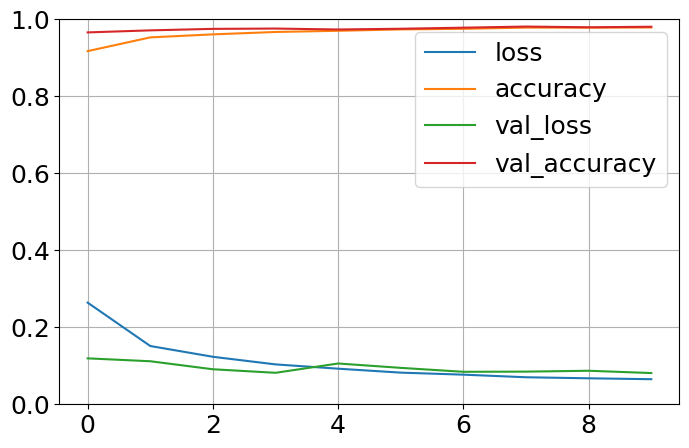

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_dim = 784))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(300, activation = 'relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(300, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'sigmoid')) 

model.summary()


model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history = model.fit(X_train_full, y_traind_full, epochs=10,
                    validation_data=(X_test_full, y_testd_full))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 1)

Notice that from the very beginnning the model gave high accuracies on both training and validation data, as well as low validation losses that gradually decreased from epoch to epoch. All of these are indications that the model is not merely memorizing the data but actually learning from the features.

The validation accuracy crossed the 98% threshold in the 10th epoch, thus satisfying the goal I set forth at the beginning of this problem.

In [12]:
model.save("mnist_keras_model.h5")

### Problem 2:

Training a deep neural network on the MRI slices. The final model has a great deal of room for improvement. In Lab 5, I build an even stronger classifier using a 2 dimensional convolutional neural network.

In Lab 3, I discovered that it's better to treat the target variable (states of dementia) as a categorical.

I will do so below.

In [13]:
file_dir = 'C:/Users/burch/OneDrive/Documents/MRI_Slices/'

labels = pd.read_csv(file_dir + 'labels.csv')
display(labels)
y = labels.CDR

,Unnamed: 0,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,Filename
0,0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_44.png
1,1,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_86.png
2,2,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_128.png
3,3,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc_44.png
4,4,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc_86.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,697,OAS1_0456_MR1,M,R,61,5.0,2.0,30.0,0.0,1637,0.780,1.072,NaN,OAS1_0456_MR1_mpr_n4_anon_111_t88_gfc_86.png
698,698,OAS1_0456_MR1,M,R,61,5.0,2.0,30.0,0.0,1637,0.780,1.072,NaN,OAS1_0456_MR1_mpr_n4_anon_111_t88_gfc_128.png
699,699,OAS1_0457_MR1,F,R,62,3.0,3.0,26.0,0.0,1372,0.766,1.279,NaN,OAS1_0457_MR1_mpr_n3_anon_111_t88_gfc_44.png
700,700,OAS1_0457_MR1,F,R,62,3.0,3.0,26.0,0.0,1372,0.766,1.279,NaN,OAS1_0457_MR1_mpr_n3_anon_111_t88_gfc_86.png


In [14]:
from matplotlib import pyplot as plt
import matplotlib

data = np.zeros([702, 36608])

for n, file_name in enumerate(labels.Filename):
    data[n,:] = np.mean(matplotlib.image.imread(file_dir + file_name),axis=2).reshape(-1)

    
    
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)
print(y_train.shape, y_test.shape)

(561,) (141,)


In [15]:
#downsampling
DS = 8             # Downsample rate, must be a factor of 36608

N_train = y_train.shape[0]  # The length of the training data
y_train = np.array(y_train)

if 36608/DS % 1 > 0:
    print("Downsample rate is not a multiple of 36608")
    DS = 1
    im_size = 36608
else:
    im_size = int(36608/DS)

Xds_train = np.zeros([N_train*DS, im_size])
yds_train = np.zeros([N_train*DS])
   
for n in range(N_train):
    for i in range(DS):
        Xds_train[n*DS+i,:] = X_train[n,i::DS]
        yds_train[n*DS+i] = y_train[n]

In [17]:
print("shape of feature training data:", Xds_train.shape)
print("shape of target training data:", yds_train.shape)

shape of feature training data: (4488, 4576)
shape of target training data: (4488,)


In [18]:
#testing data
y_test = np.matrix(y_test)

Xds_test = np.zeros([141*DS, im_size])
yds_test = np.zeros([141*DS])

for n in range(140):
    for i in range(DS):
        Xds_test[n*DS+i,:] = X_test[n,i::DS]
        yds_test[n*DS+i] = y_test[0,n]

print(Xds_test.shape)
print(yds_test.shape)

(1128, 4576)
(1128,)


In [19]:
y_traind = pd.get_dummies(yds_train)
y_testd = pd.get_dummies(yds_test)

This problem would prove elusive. I took a number of approaches, including removing the bias vector and all methods of addressing overfitting in the previous problem. 

I suspect that the problem is that the dimensionality of the data set is too high and the number of samples too low. (This was also an issue I ran into several times when building a classifier for the 20 newsgroups dataset featured elsewhere on my github.)

The best validation accuracy I achieved was 57%; that particular model had outrageous validation loss. I present the following simple model, which achieved 54% validation accuracy, because it has to its merit metrics that indicate it is not overfitting. As such, it would be a good starting off point for improving this classifier.

However, as I said above, ultimately I determined that there are other neural networks more suited for classifying the MRI slices.

It's worth noting that the original instructions for this lab challenged students to build a classifier which did better than classifying everything as the same label (which would yield 25% accuracy). On that front this solution is a success.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 4576)              0         
                                                                 
 dense_19 (Dense)            (None, 30)                137280    
                                                                 
 dense_20 (Dense)            (None, 4)                 120       
                                                                 
Total params: 137,400
Trainable params: 137,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
141/141 [==============================] - 1s 4ms/step - loss: 0.1437 - accuracy: 0.5775 - val_loss: 0.1572 - val_accuracy: 0.5461
Epoch 2/20
141/141 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.5787 - val_loss: 0.1479 - val_accuracy: 0.5461
Epoch 3/20
141/141 [========

(0.0, 1.0)

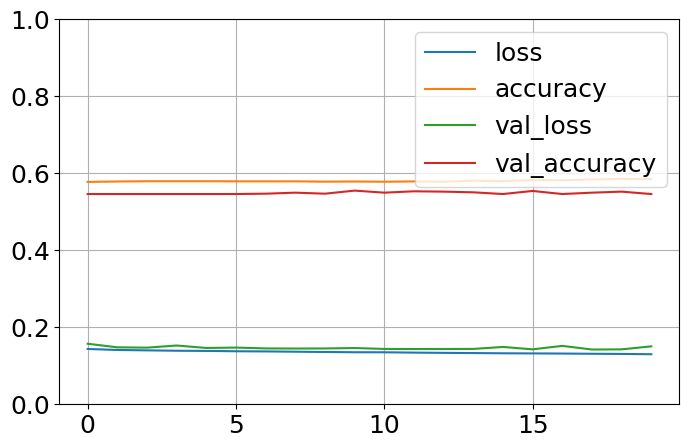

In [22]:
MRI_model = Sequential()
MRI_model.add(keras.layers.Flatten(input_dim = 4576))
MRI_model.add(keras.layers.Dense(30, activation = 'relu', use_bias = False))
MRI_model.add(keras.layers.Dense(4, activation = 'sigmoid', use_bias = False))

MRI_model.summary()

MRI_model.compile(loss="mean_squared_error",
              optimizer="sgd",
              metrics=["accuracy"])

history = MRI_model.fit(Xds_train, y_traind, epochs=20,
                    validation_data=(Xds_test, y_testd))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 1)